##### **Optuna** will be used to determine the best **Hyperparameters** for Decision Tree and Random Forest.

In [132]:
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings("ignore")

In [133]:
# loading the data
df = pd.read_csv('pivoted_financial_data.csv')
df.head()

,Name,Total income_1,Total income_2,Total income_3,Total income_4,Total income_5,Total income_6,Total income_7,Total income_8,Total income_9,...,Cash balance_3,Cash balance_4,Cash balance_5,Cash balance_6,Cash balance_7,Cash balance_8,Cash balance_9,Cash balance_10,Cash balance_11,Label
0,20 MICRONS LTD.,3097.0,3316.2,3527.6,3741.8,3922.0,4383.1,4979.3,4379.6,5229.5,...,1.0,1.6,1.5,2.2,2.1,2.1,0.3,0.9,0.9,0
1,360 ONE WAM LTD.,2138.3,3717.4,4115.0,4549.7,7719.4,6070.7,5668.6,7669.8,5966.4,...,42.0,0.6,0.5,5.2,0.2,0.7,0.1,0.1,0.1,0
2,3C IT SOLUTIONS & TELECOMS (INDIA) LTD.,51.9,41.1,102.1,164.5,228.5,405.3,672.4,629.4,302.1,...,0.5,0.0,0.1,0.0,0.2,0.0,0.9,0.0,0.0,0
3,3I INFOTECH LTD.,5649.9,5175.8,13816.7,4846.2,4343.8,6723.0,4456.4,6819.4,3201.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3M INDIA LTD.,18401.5,19434.6,22435.0,25073.2,26240.3,28415.9,29230.6,24472.3,31143.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [134]:
df_temp = df.drop(columns = ['Name'])
corr_matrix = df_temp.corr()
label_corr = corr_matrix['Label'].sort_values(ascending=False)
print(label_corr.head(50))

Label                                    1.000000
Depreciation as % of PBDITA_3            0.091839
Depreciation as % of PBDITA_9            0.085469
Sales / Net fixed assets_4               0.069977
Other long term assets_5                 0.064607
Other long term assets_6                 0.063636
Depreciation as % of PBDITA_10           0.053491
Long term investments_1                  0.036911
Long term investments_2                  0.030720
Depreciation as % of PBDITA_11           0.027658
Other long term assets_4                 0.021166
Other long term assets_7                 0.019503
PAT as % of PBDITA_8                     0.018933
Long term investments_4                  0.018573
Long term investments_3                  0.017685
Net property, plant and equipment_1      0.016908
Long term loans & advances_4             0.015279
Depreciation as % of PBDITA_1            0.015236
Net property, plant and equipment_2      0.013788
Long term loans & advances_5             0.013728


In [135]:
non_numeric_columns = df[['Name','Label']]
numeric_columns = df.drop(columns = ['Name','Label'])
# numeric_columns = df[[
#     'Depreciation as % of PBDITA_3',
#     'Depreciation as % of PBDITA_9',
#     'Sales / Net fixed assets_4',
#     'Other long term assets_5',
#     'Other long term assets_6',
#     'Depreciation as % of PBDITA_10',
#     'Long term investments_1',
#     'Long term investments_2'
# ]]
# numeric_columns = df[[
#                       'Profit after tax_1',
#                       'Profit after tax_2',
#                       'Profit after tax_3',
#                       'Profit after tax_4',
#                       'Profit after tax_5',
#                       'Profit after tax_6',
#                       'Profit after tax_7',
#                       'Profit after tax_8',
#                       'Profit after tax_9',
#                       'Profit after tax_10',
#                       'PBT_1',
#                       'PBT_2',
#                       'PBT_3',
#                       'PBT_4',
#                       'PBT_5',
#                       'PBT_6',
#                       'PBT_7',
#                       'PBT_8',
#                       'PBT_9',
#                       'PBT_10',
#                       'PBDITA_1',
#                       'PBDITA_2',
#                       'PBDITA_3',
#                       'PBDITA_4',
#                       'PBDITA_5',
#                       'PBDITA_6',
#                       'PBDITA_7',
#                       'PBDITA_8',
#                       'PBDITA_9',
#                       'PBDITA_10',
#                       'PAT as % of PBDITA_1',
#                       'PAT as % of PBDITA_2',
#                       'PAT as % of PBDITA_3',
#                       'PAT as % of PBDITA_4',
#                       'PAT as % of PBDITA_5',
#                       'PAT as % of PBDITA_6',
#                       'PAT as % of PBDITA_7',
#                       'PAT as % of PBDITA_8',
#                       'PAT as % of PBDITA_9',
#                       'PAT as % of PBDITA_10',
#                       'Change in stock_1',
#                       'Change in stock_2',
#                       'Change in stock_3',
#                       'Change in stock_4',
#                       'Change in stock_5',
#                       'Change in stock_6',
#                       'Change in stock_7',
#                       'Change in stock_8',
#                       'Change in stock_9',
#                       'Change in stock_10',
#                       'Current ratio (times)_1',
#                       'Current ratio (times)_2',
#                       'Current ratio (times)_3',
#                       'Current ratio (times)_4',
#                       'Current ratio (times)_5',
#                       'Current ratio (times)_6',
#                       'Current ratio (times)_7',
#                       'Current ratio (times)_8',
#                       'Current ratio (times)_9',
#                       'Current ratio (times)_10',
#                       'Quick ratio (times)_1',
#                       'Quick ratio (times)_2',
#                       'Quick ratio (times)_3',
#                       'Quick ratio (times)_4',
#                       'Quick ratio (times)_5',
#                       'Quick ratio (times)_6',
#                       'Quick ratio (times)_7',
#                       'Quick ratio (times)_8',
#                       'Quick ratio (times)_9',
#                       'Quick ratio (times)_10',
#                       'Long term investments_1',
#                       'Long term investments_2',
#                       'Long term investments_3',
#                       'Long term investments_4',
#                       'Long term investments_5',
#                       'Long term investments_6',
#                       'Long term investments_7',
#                       'Long term investments_8',
#                       'Long term investments_9',
#                       'Long term investments_10',
#                       'Long term loans & advances_1',
#                       'Long term loans & advances_2',
#                       'Long term loans & advances_3',
#                       'Long term loans & advances_4',
#                       'Long term loans & advances_5',
#                       'Long term loans & advances_6',
#                       'Long term loans & advances_7',
#                       'Long term loans & advances_8',
#                       'Long term loans & advances_9',
#                       'Long term loans & advances_10',
#                       'Creditors turnover (times)_1',
#                       'Creditors turnover (times)_2',
#                       'Creditors turnover (times)_3',
#                       'Creditors turnover (times)_4',
#                       'Creditors turnover (times)_5',
#                       'Creditors turnover (times)_6',
#                       'Creditors turnover (times)_7',
#                       'Creditors turnover (times)_8',
#                       'Creditors turnover (times)_9',
#                       'Creditors turnover (times)_10',
#                         'Change in total income_1',
#                         'Change in total income_2',
#                         'Change in total income_3',
#                         'Change in total income_4',
#                         'Change in total income_5',
#                         'Change in total income_6',
#                         'Change in total income_7',
#                         'Change in total income_8',
#                         'Change in total income_9',
#                         'Change in total income_10',
#                         'Change in PAT net of P&E_1',
#                         'Change in PAT net of P&E_2',
#                         'Change in PAT net of P&E_3',
#                         'Change in PAT net of P&E_4',
#                         'Change in PAT net of P&E_5',
#                         'Change in PAT net of P&E_6',
#                         'Change in PAT net of P&E_7',
#                         'Change in PAT net of P&E_8',
#                         'Change in PAT net of P&E_9',
#                         'Change in PAT net of P&E_10',
#                         'Change in working capital assets_1',
#                         'Change in working capital assets_2',
#                         'Change in working capital assets_3',
#                         'Change in working capital assets_4',
#                         'Change in working capital assets_5',
#                         'Change in working capital assets_6',
#                         'Change in working capital assets_7',
#                         'Change in working capital assets_8',
#                         'Change in working capital assets_9',
#                         'Change in working capital assets_10'
# ]]
y = df['Label']
X = numeric_columns

Using Standard Scaler to Normalize the Numeric Values

In [136]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns = numeric_columns.columns)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
# stratify = y ensures that the same proportion of each class is maintained in both train and test datasets
sm = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state = 42)
# we only change the Training Datasets to oversample
X_train_resampled,y_train_resampled = sm.fit_resample(X_train,y_train)
# we should not resample the test data, it is not realistic to have equal number of bankrupt and non-bankrupt companies
X_test_resampled,y_test_resampled = sm.fit_resample(X_test,y_test)
print(f"Oversampled Training Dataset : \n {y_train_resampled.value_counts()}")
print(f"Training Dataset : \n {y_train.value_counts()}")
print(f"Oversampled Testing Dataset : \n {y_test_resampled.value_counts()}")
print(f"Testing Dataset : \n {y_test.value_counts()}")

Oversampled Training Dataset : 
 Label
0    3700
1    3700
Name: count, dtype: int64
Training Dataset : 
 Label
0    3700
1      56
Name: count, dtype: int64
Oversampled Testing Dataset : 
 Label
0    1587
1    1587
Name: count, dtype: int64
Testing Dataset : 
 Label
0    1587
1      24
Name: count, dtype: int64


In [138]:
class_weight = np.sum(y_train == 0)/np.sum(y_train == 1)

In [139]:
classifiers = {
    "DT" : DecisionTreeClassifier(criterion='gini',
                                  max_depth = 10,
                                  min_samples_split=5,
                                  class_weight = 'balanced', 
                                  random_state = 42),
    
    "RF" : RandomForestClassifier(criterion='gini',
                                  n_estimators = 200, 
                                  max_depth = 10,
                                  min_samples_split = 5,
                                  class_weight = 'balanced',
                                  random_state=42),
    
    "XGB" : XGB.XGBClassifier(objective = "binary:logistic",
                              eval_metric = "aucpr",
                              use_label_encoder = False,
                              scale_pos_weight = class_weight,
                              random_state = 42),
    
    "LogReg" : LogisticRegression(class_weight = 'balanced',
                                  random_state = 42),
    
    "SVM" : LinearSVC(class_weight = 'balanced',
                      random_state=31,
                      loss = 'hinge',
                      fit_intercept=False)
} 

In [140]:
clf_dt = classifiers["DT"]
clf_rf = classifiers["RF"]
clf_xgb = classifiers["XGB"]
clf_lr = classifiers["LogReg"]
clf_svm = classifiers["SVM"]

In [141]:
def print_metrics(clf,y_test,y_pred):
    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred, average='macro')
    recall = metrics.recall_score(y_test,y_pred, average='macro')
    f1 = metrics.f1_score(y_test,y_pred, average='macro')
    print(f"For the {clf} Classifier: \n")
    print(f"Accuracy : {accuracy: .4f}")
    print(f"Precision : {precision : .4f}")
    print(f"Recall : {recall : .4f}")
    print(f"F1 Score : {f1 : .4f}")
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.plot(recall,precision,marker = '.', label = 'P-R Curve')
    plt.legend()
    plt.show()

In [142]:
def print_confusion_matrix(clf,y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis = 1)[:,np.newaxis]
    # cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Confusion Matrix for the {clf} Classifier")
    plt.show()
    # normalized_cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(normalized_cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Normalized Confusion Matrix for {clf} Classifier: ")

For the SVM Classifier: 

Accuracy :  0.8318
Precision :  0.5295
Recall :  0.7915
F1 Score :  0.5121


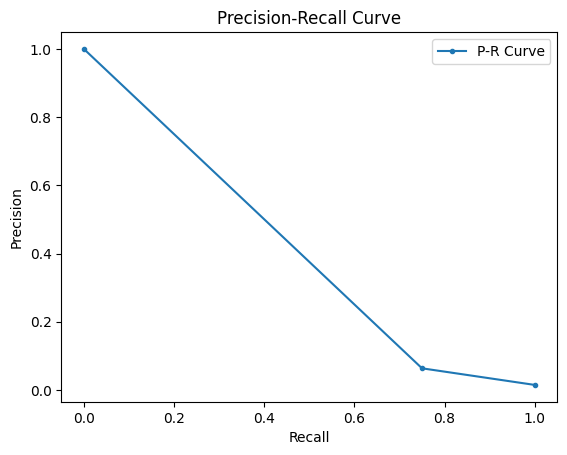

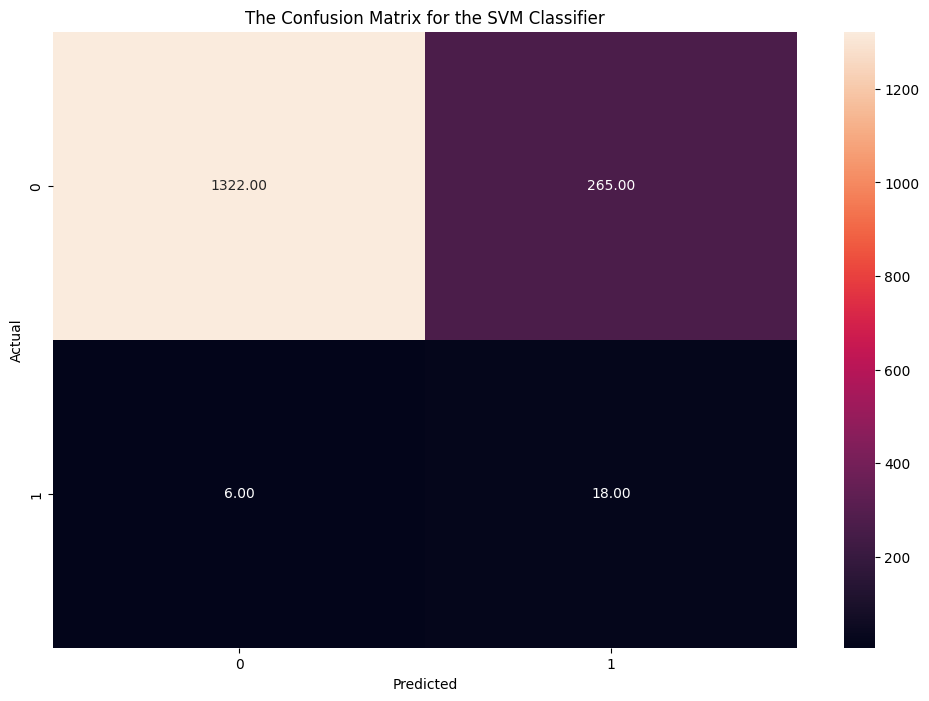

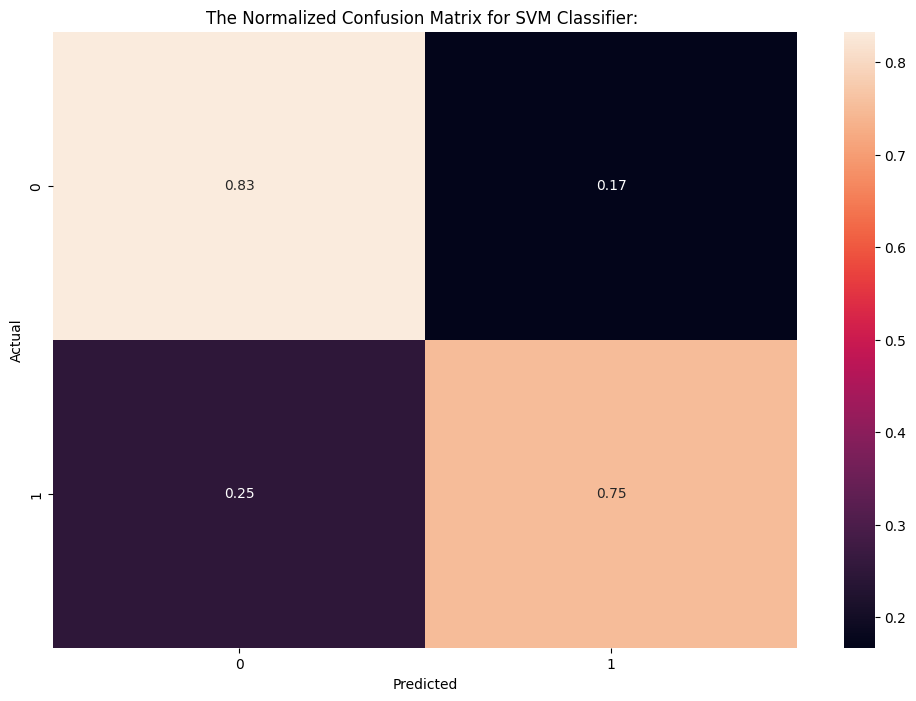

In [143]:
clf_svm.fit(X_train_resampled,y_train_resampled)
y_pred = clf_svm.predict(X_test)
print_metrics("SVM",y_test,y_pred)
print_confusion_matrix("SVM",y_test,y_pred)

For the Decision Tree Classifier: 

Accuracy :  0.9286
Precision :  0.5404
Recall :  0.6765
F1 Score :  0.5554


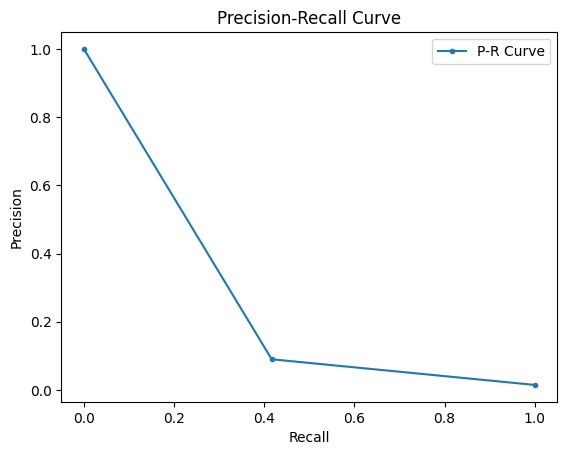

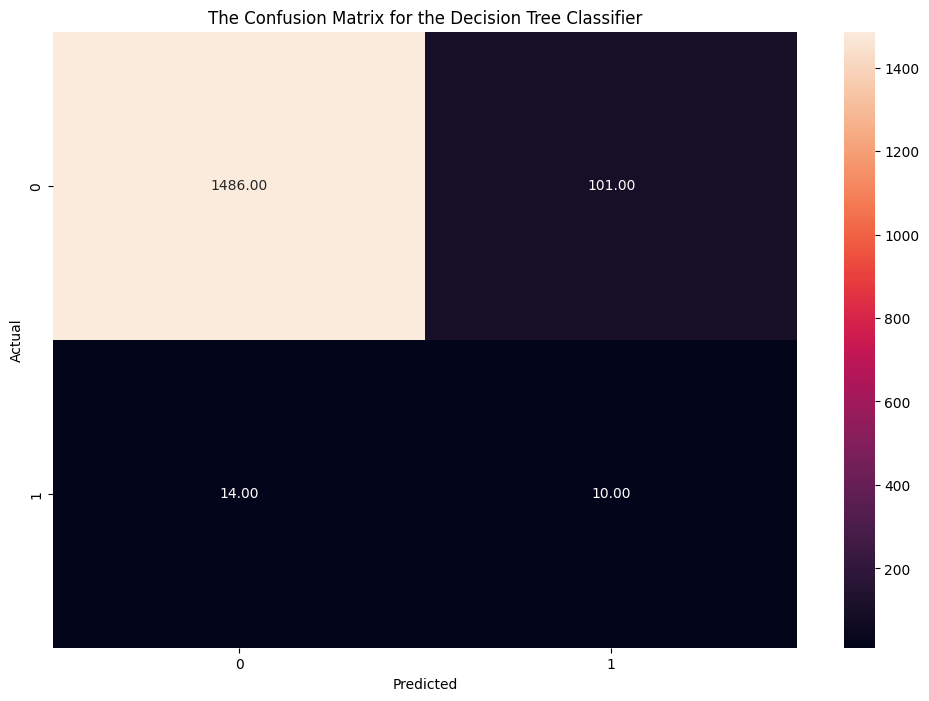

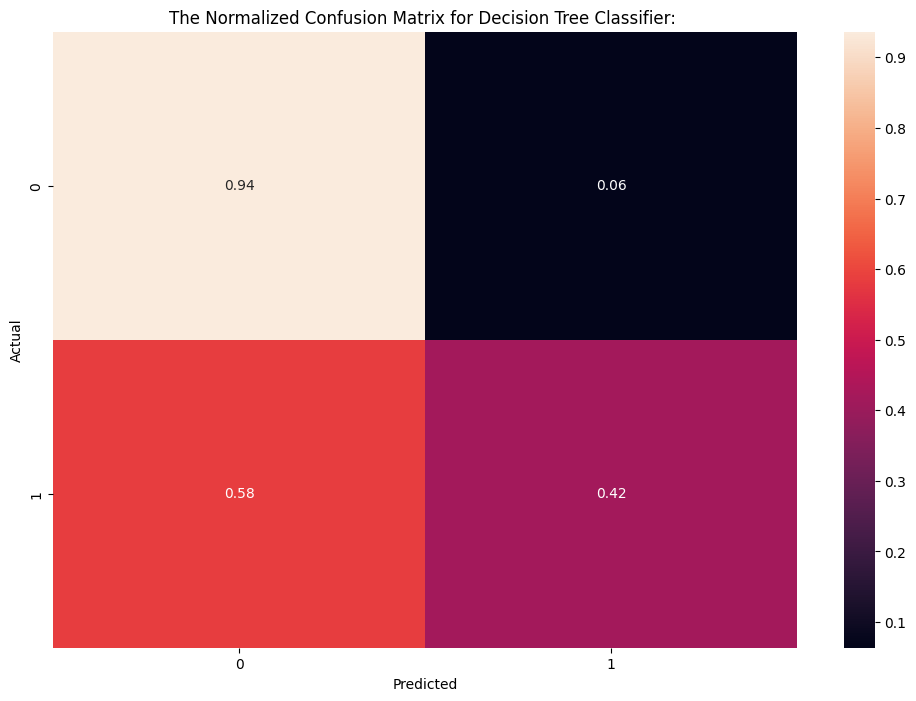

In [144]:
w_train = compute_sample_weight('balanced',y_train_resampled)
# training the model using the oversampled dataset
clf_dt.fit(X_train_resampled,y_train_resampled, sample_weight = w_train)
# testing the model using the imbalanced dataset
y_pred = clf_dt.predict(X_test)
print_metrics("Decision Tree",y_test,y_pred)
print_confusion_matrix("Decision Tree",y_test,y_pred)

For the Random Forest Classifier: 

Accuracy :  0.9665
Precision :  0.6125
Recall :  0.7573
F1 Score :  0.6539


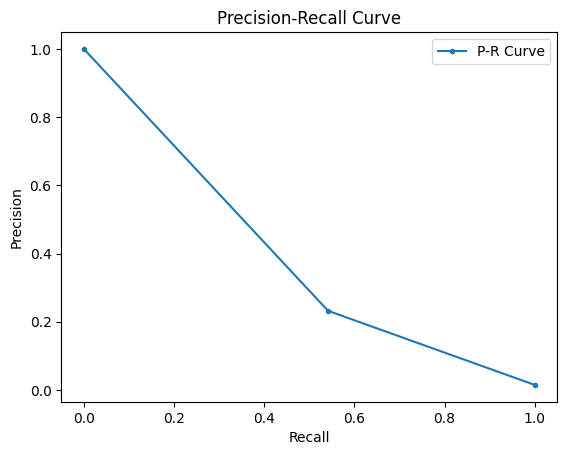

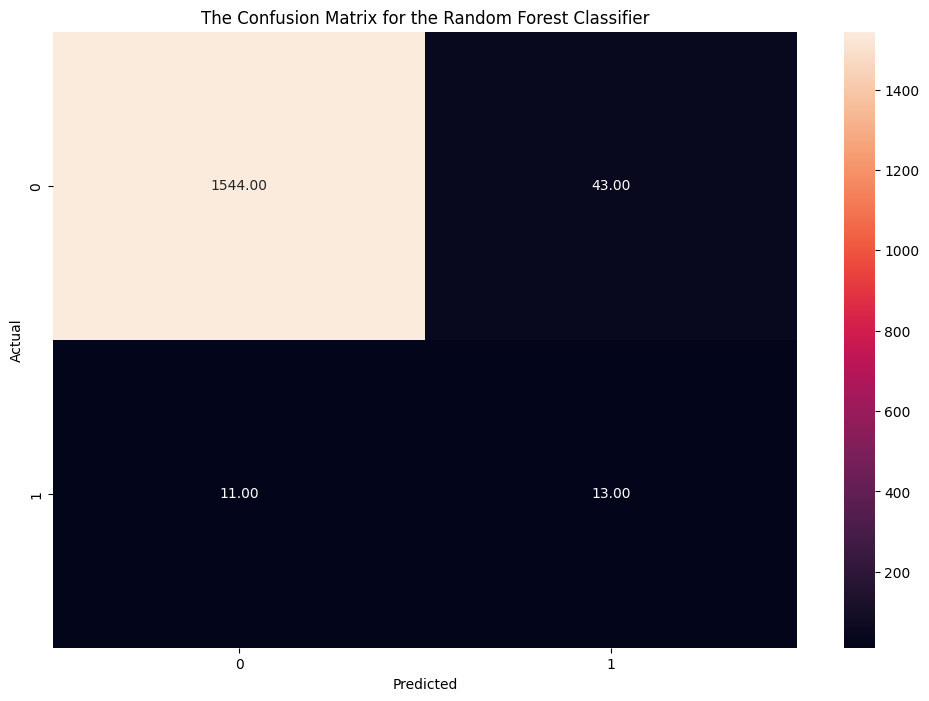

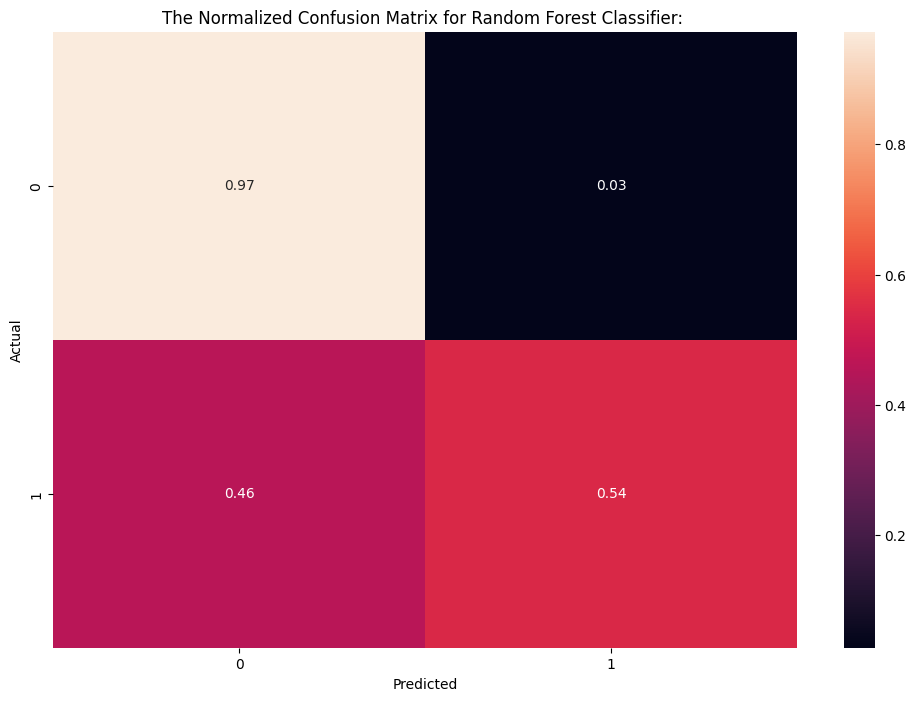

In [145]:
# training the model using the oversampled dataset
clf_rf.fit(X_train_resampled,y_train_resampled, sample_weight = w_train)
# testing the model using the imbalanced dataset
y_pred = clf_rf.predict(X_test)
print_metrics("Random Forest",y_test,y_pred)
print_confusion_matrix("Random Forest",y_test,y_pred)

- This situation of testing using an oversampled dataset is not realistic
- It is not possible to have equal number of **bankrupt** and **non-bankrupt** companies in our testing dataset

For the Random Forest Resampled Classifier: 

Accuracy :  0.8283
Precision :  0.8583
Recall :  0.8283
F1 Score :  0.8246


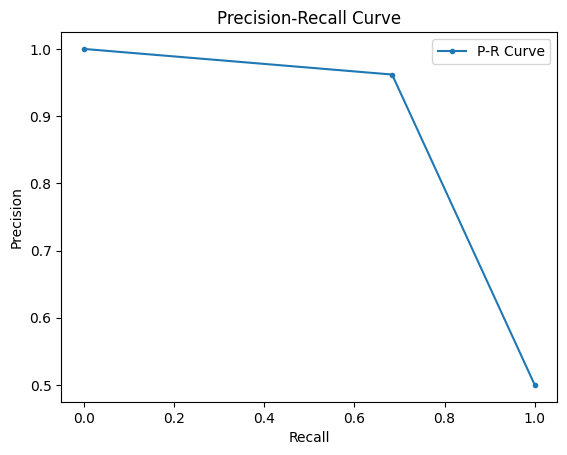

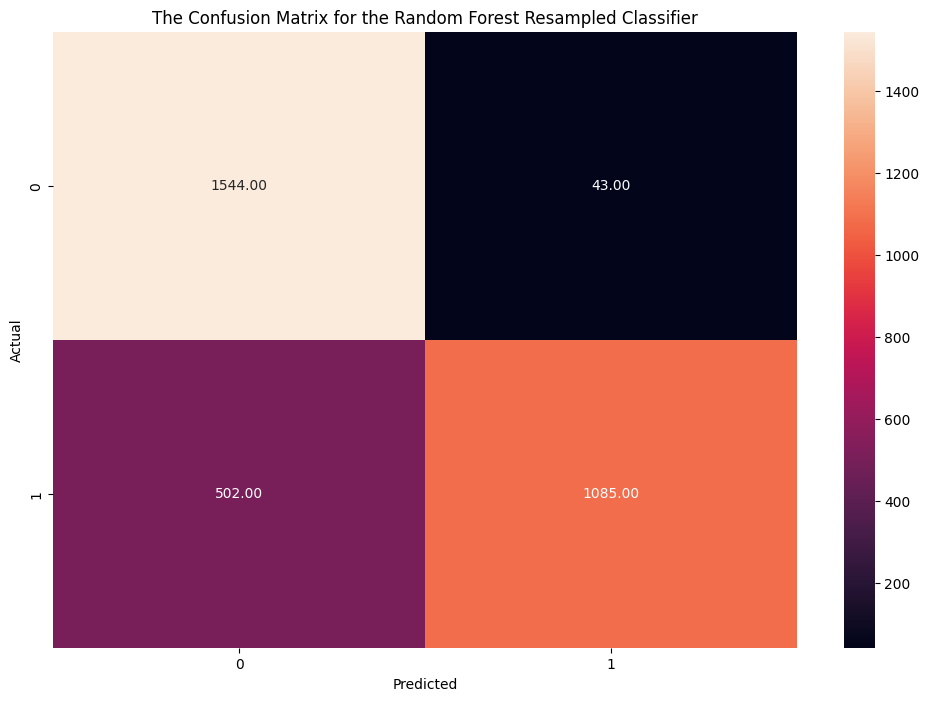

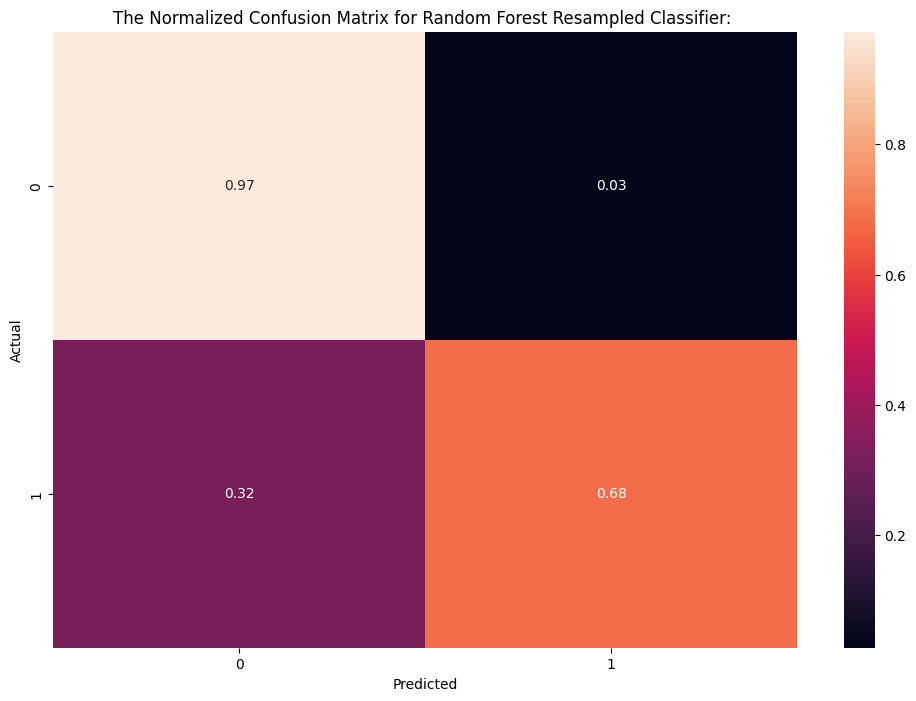

In [146]:
# training the model using the oversampled dataset
clf_rf.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_rf.predict(X_test_resampled)
print_metrics("Random Forest Resampled",y_test_resampled,y_pred)
print_confusion_matrix("Random Forest Resampled",y_test_resampled,y_pred)

For the XGBoost Classifier: 

Accuracy :  0.9739
Precision :  0.6040
Recall :  0.6380
F1 Score :  0.6184


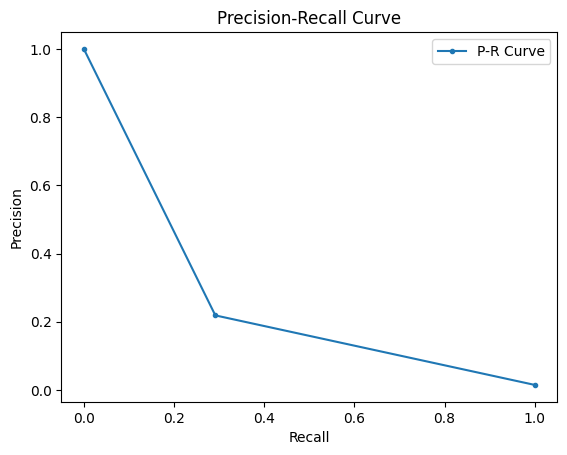

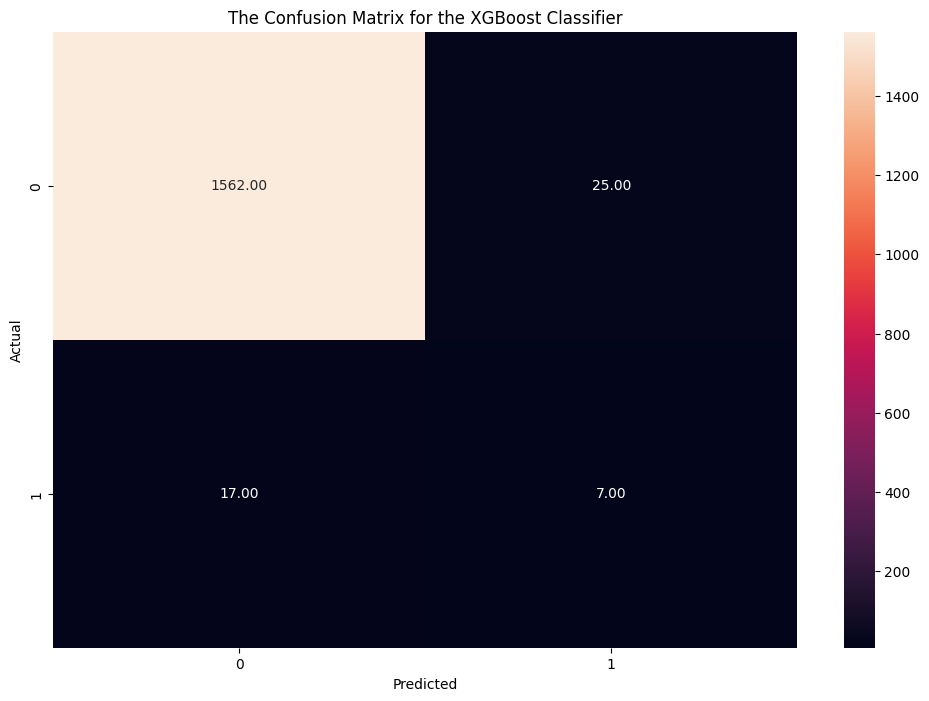

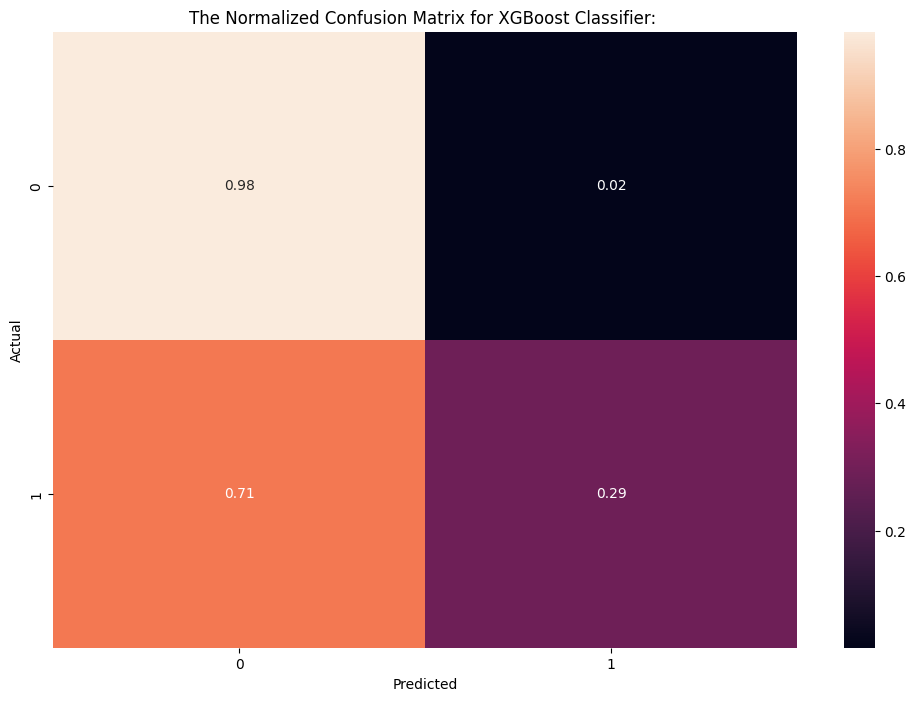

In [147]:
clf_xgb.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_xgb.predict(X_test)
print_metrics("XGBoost",y_test,y_pred)
print_confusion_matrix("XGBoost",y_test,y_pred)

For the Logistic Regression Classifier: 

Accuracy :  0.8634
Precision :  0.5276
Recall :  0.7255
F1 Score :  0.5195


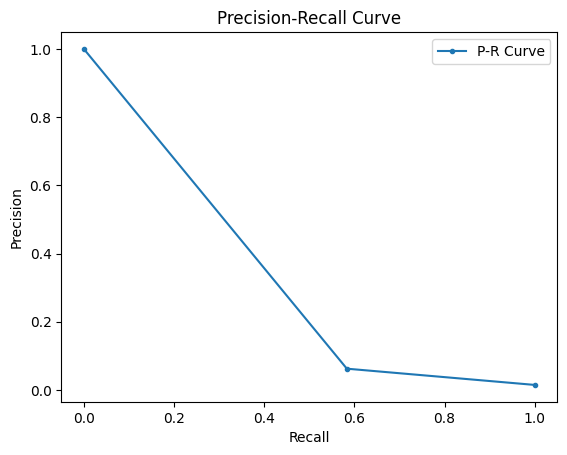

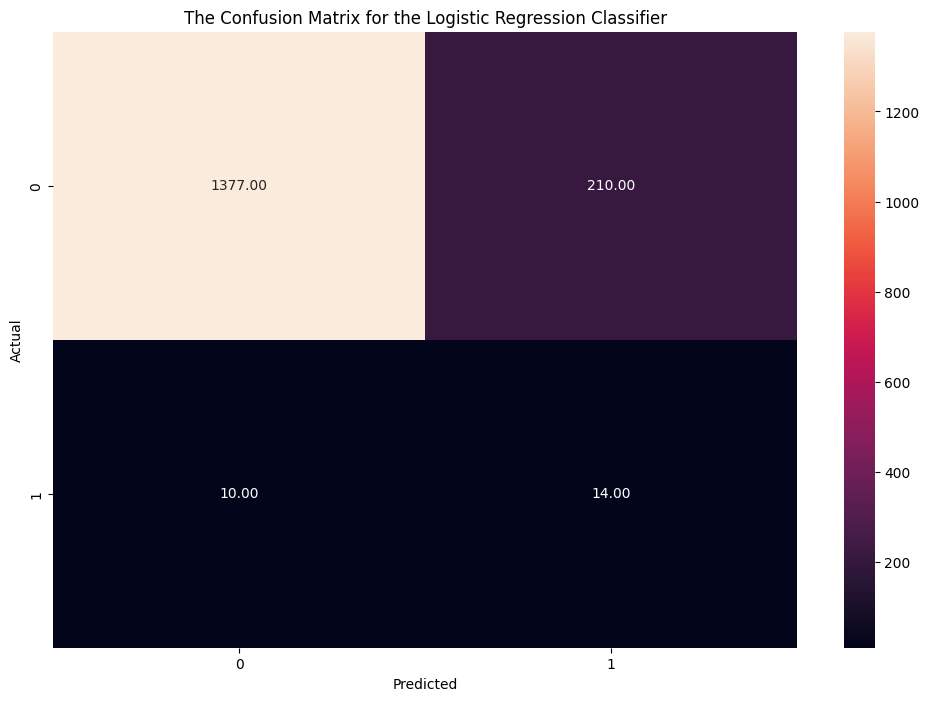

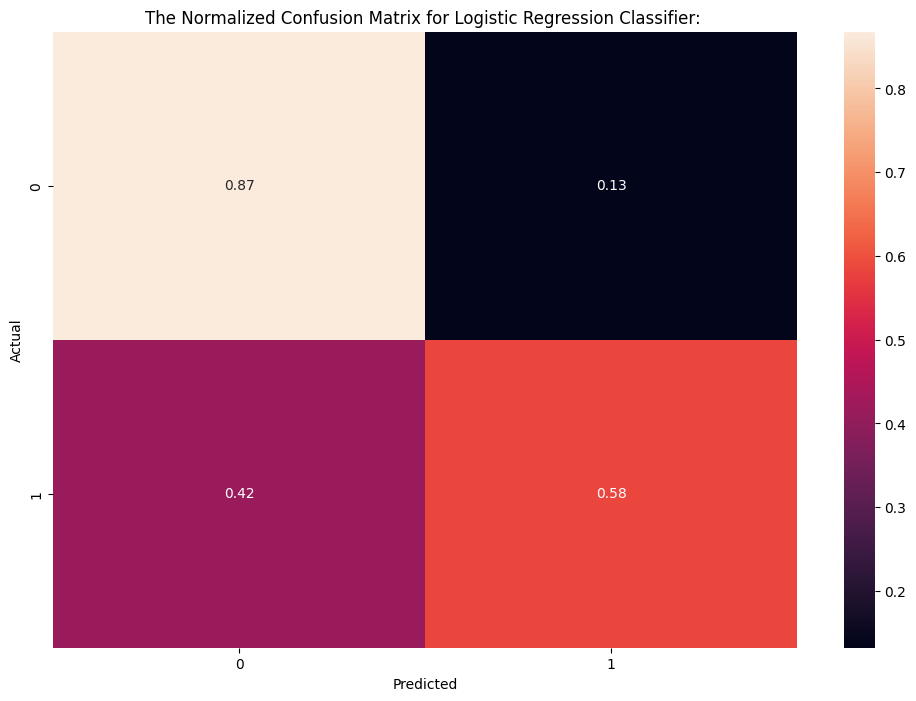

In [148]:
clf_lr.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_lr.predict(X_test)
print_metrics("Logistic Regression",y_test, y_pred)
print_confusion_matrix("Logistic Regression", y_test, y_pred)